In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import modules.deep_model as DeepModel
import modules.model as Model 
import tensorflow as tf
import warnings
import numpy as np
import os

warnings.filterwarnings('ignore')
tf.config.list_physical_devices('GPU')

[]

In [5]:
# # run if have GPU
# physical_devices = tf.config.list_physical_devices('GPU') 
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [4]:
X_train, y_train = Model.loadData("./data/data/train")
X_train = X_train.fillna("")

X_test, y_test = Model.loadData("./data/data/test")
X_test = X_test.fillna("")

display(X_train, y_train)
display(X_test, y_test)


,raw_comment,normalize_comment,emoji_decode
0,form k đẹp lắm,form không đẹp lắm,
1,Áo Rộng thật sự\nGl nhanh\nChật lươ...,áo rộng thật sự nhanh chật lượng v...,
2,Màu túi hơi tối do với ảnh chụp,màu túi hơi tối do ảnh chụp,
3,Chất liệu vải k ổn lắm,chất liệu vải không ổn lắm,
4,"Mã ""màu đen"" hiện lên áo màu đen, còn ...",mã màu đen hiện lên áo màu đen còn mã...,
...,...,...,...
11359,"Khi bán combo ghi 3 đôi, nhưng nhận chỉ ...",bán combo ghi đôi nhưng nhận chỉ đôi ta...,
11360,"Áo đẹp, from chuẩn. Sẽ ủng hộ tiếp ạ !",áo đẹp from chuẩn sẽ ủng hộ tiếp,
11361,Đặt màu trắng kem thì giao màu xanh đen...,đặt màu trắng kem giao màu xanh đen giao...,expressionless
11362,Đồ chơi tí hon.\nShop nên dừng bán sp ...,đồ chơi tí hon nên dừng bán sản phẩ...,


,label
0,0
1,1
2,0
3,0
4,0
...,...
11359,0
11360,1
11361,0
11362,0


,raw_comment,normalize_comment,emoji_decode
0,Shop bán hàng kỉ quấn đầy đủ. Chất l...,bán hàng kỉ quấn đầy đủ chất lượn...,
1,"Đặt xl, áo ghi xl nhưng lại bé tí tẹo ...",đặt xl áo ghi xl nhưng bé tí tẹo ngang ...,
2,Kẹp rất rất đẹp săn được giá sale h...,kẹp rất rất đẹp săn được giá sale h...,
3,K nghĩ áo đẹp vậy đâu giao hàng nhanh k...,không nghĩ áo đẹp giao hàng nhanh không ...,
4,Hôm nay mới nhận đc nhưng nhìn qua thâ...,hôm nay mới nhận được nhưng nhìn qua...,
...,...,...,...
2837,Mình đặt 2 dây buộc tóc nhưng lại chi...,đặt dây buộc tóc nhưng chỉ nhận đưo...,star slightly_smiling_face slightly_smiling_fa...
2838,"Chất vải đẹp, có vẻ mát, giao hàng nha...",chất vải đẹp có vẻ mát giao hàng nhanh...,
2839,Dây nhìn tạm. K đẹp. Mắc sai dây mình ...,dây nhìn tạm không đẹp mắc sai dây pha...,
2840,Quần đẹp chất lượng ok nhưng chữ ru...,quần đẹp chất lượng ok nhưng chữ cu...,


,label
0,1
1,0
2,1
3,1
4,1
...,...
2837,0
2838,1
2839,0
2840,1


In [5]:
X_train_comments = Model.convertToNFX(X_train['normalize_comment'], 'NFC')
X_test_comments = Model.convertToNFX(X_test['normalize_comment'], 'NFC')

In [6]:
tokenizer = DeepModel.tokenize(X_train_comments)
token_train_cmts = tokenizer.texts_to_sequences(X_train_comments)
padded_train_cmts = DeepModel.padding(token_train_cmts)

In [7]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = padded_train_cmts.shape[1]
neurons = 10
dropout = 0.2

lstm_model = DeepModel.defineLSTM(vocab_size, embedding_dim, neurons, dropout)

AttributeError: 'tuple' object has no attribute 'layer'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          358500    
_________________________________________________________________
lstm (LSTM)                  (None, 10)                4440      
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 362,962
Trainable params: 362,962
Non-trainable params: 0
_________________________________________________________________


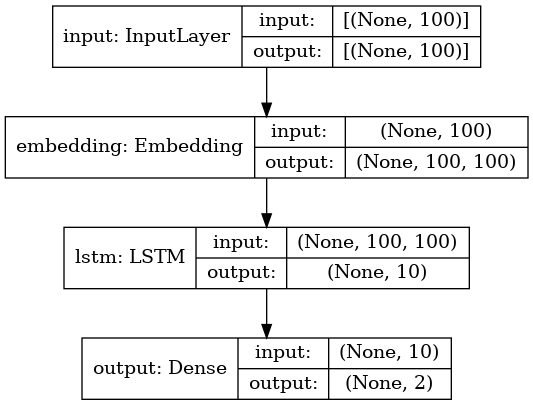

In [10]:
lstm_model.summary()
plot_model(lstm_model, to_file="./images/LSTM_sentiment.png", show_shapes=True, show_layer_names=True)

In [11]:
batch_size = 32
epochs = 10
save_path = "./models/LSTM_sentiment.h5"
DeepModel.fit(lstm_model, padded_train_cmts, y_train, batch_size, epochs, save_path) 

Epoch 1/10
320/320 [==============================] - 57s 172ms/step - loss: 0.5499 - accuracy: 0.7813 - val_loss: 0.3498 - val_accuracy: 0.8610
Epoch 2/10
320/320 [==============================] - 57s 179ms/step - loss: 0.2856 - accuracy: 0.8935 - val_loss: 0.3330 - val_accuracy: 0.8646
Epoch 3/10
320/320 [==============================] - 58s 181ms/step - loss: 0.2397 - accuracy: 0.9122 - val_loss: 0.3340 - val_accuracy: 0.8619
Epoch 4/10
320/320 [==============================] - 58s 181ms/step - loss: 0.2112 - accuracy: 0.9244 - val_loss: 0.3402 - val_accuracy: 0.8672
Epoch 5/10
320/320 [==============================] - 59s 183ms/step - loss: 0.1976 - accuracy: 0.9301 - val_loss: 0.3603 - val_accuracy: 0.8690
Epoch 6/10
320/320 [==============================] - 59s 183ms/step - loss: 0.1744 - accuracy: 0.9397 - val_loss: 0.3668 - val_accuracy: 0.8602
Epoch 7/10
320/320 [==============================] - 61s 191ms/step - loss: 0.1643 - accuracy: 0.9445 - val_loss: 0.3858 - val_ac

In [12]:
token_test_cmts = tokenizer.texts_to_sequences(X_test_comments)
padded_test_cmts = DeepModel.padding(token_test_cmts)

In [13]:
prediction = lstm_model.predict_proba(padded_test_cmts)

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      1410
    Positive       0.86      0.86      0.86      1432

    accuracy                           0.86      2842
   macro avg       0.86      0.86      0.86      2842
weighted avg       0.86      0.86      0.86      2842



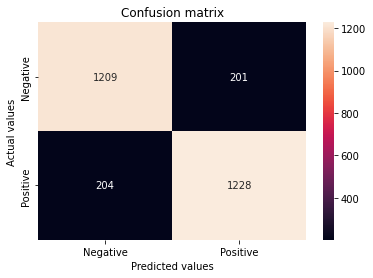

In [18]:
inverted = np.argmax(prediction, axis=1)
Model.confusionMatrix(y_test, inverted)

In [19]:
epochs = 20
save_path = "./models/LSTM_sentiment_50.h5"
neurons = 50

lstm_model_50 = DeepModel.defineLSTM(vocab_size, embedding_dim, neurons, dropout)
DeepModel.fit(lstm_model_50, padded_train_cmts, y_train, batch_size, epochs, save_path) 

Epoch 1/50
320/320 [==============================] - 56s 170ms/step - loss: 0.4979 - accuracy: 0.7689 - val_loss: 0.3307 - val_accuracy: 0.8593
Epoch 2/50
320/320 [==============================] - 58s 182ms/step - loss: 0.2737 - accuracy: 0.8957 - val_loss: 0.3305 - val_accuracy: 0.8672
Epoch 3/50
320/320 [==============================] - 58s 182ms/step - loss: 0.2230 - accuracy: 0.9170 - val_loss: 0.3236 - val_accuracy: 0.8760
Epoch 4/50
320/320 [==============================] - 58s 182ms/step - loss: 0.1978 - accuracy: 0.9305 - val_loss: 0.3449 - val_accuracy: 0.8575
Epoch 5/50
320/320 [==============================] - 58s 183ms/step - loss: 0.1885 - accuracy: 0.9326 - val_loss: 0.3616 - val_accuracy: 0.8637
Epoch 6/50
320/320 [==============================] - 59s 185ms/step - loss: 0.1576 - accuracy: 0.9445 - val_loss: 0.3842 - val_accuracy: 0.8602
Epoch 7/50
320/320 [==============================] - 59s 184ms/step - loss: 0.1439 - accuracy: 0.9484 - val_loss: 0.3972 - val_ac

KeyboardInterrupt: 

In [5]:
m = tf.keras.models.load_model("./models/LSTM_sentiment.h5")

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [9]:
!conda list

# packages in environment at /home/manhcuong/anaconda3/envs/py-3.8:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
_tflow_select             2.1.0                       gpu  
absl-py                   0.13.0           py38h06a4308_0  
aiohttp                   3.7.4.post0      py38h7f8727e_2  
alsa-lib                  1.2.3                h516909a_0    conda-forge
astor                     0.8.1            py38h06a4308_0  
astunparse                1.6.3                      py_0  
async-timeout             3.0.1            py38h06a4308_0  
atk-1.0                   2.36.0               h3371d22_4    conda-forge
attrs                     21.2.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backp